### SID 2179088 Group One

## 1. Importing

### Importing libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
import string
import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import datetime

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ngoc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ngoc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Importing dataset

In [2]:
dataset = pd.read_csv('vaccination_tweets-1.csv')
dataset.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971510000,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,4/8/2009 17:52,405,1692,3247,False,12/20/2020 6:06,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250000,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",9/21/2009 15:27,834,666,178,False,12/13/2020 16:27,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140110000,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",6/25/2020 23:30,10,88,155,False,12/12/2020 20:33,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918830000,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",9/10/2008 11:28,49165,3933,21853,True,12/12/2020 20:23,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604960000,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,4/23/2020 17:58,152,580,1473,False,12/12/2020 20:17,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


## 2. Exploratory Data Analysis

In [3]:
print("Total tweets in the dataset: {}".format(dataset.shape[0]))

Total tweets in the dataset: 11020


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11020 entries, 0 to 11019
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                11020 non-null  int64 
 1   user_name         11020 non-null  object
 2   user_location     8750 non-null   object
 3   user_description  10341 non-null  object
 4   user_created      11020 non-null  object
 5   user_followers    11020 non-null  int64 
 6   user_friends      11020 non-null  int64 
 7   user_favourites   11020 non-null  int64 
 8   user_verified     11020 non-null  bool  
 9   date              11020 non-null  object
 10  text              11020 non-null  object
 11  hashtags          8438 non-null   object
 12  source            11019 non-null  object
 13  retweets          11020 non-null  int64 
 14  favorites         11020 non-null  int64 
 15  is_retweet        11020 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 1.2+ MB


In [5]:
dataset.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

In [6]:
text_dataset = dataset.drop(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'hashtags', 'source', 'is_retweet'], axis=1)
text_dataset.head()

,date,text,retweets,favorites
0,12/20/2020 6:06,Same folks said daikon paste could treat a cyt...,0,0
1,12/13/2020 16:27,While the world has been on the wrong side of ...,1,1
2,12/12/2020 20:33,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,0,0
3,12/12/2020 20:23,"Facts are immutable, Senator, even when you're...",446,2129
4,12/12/2020 20:17,Explain to me again why we need a vaccine @Bor...,0,0


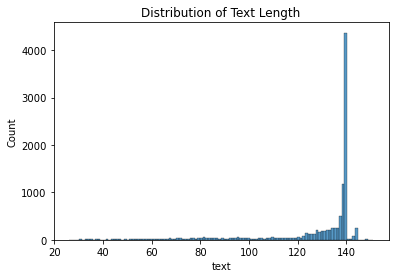

In [7]:
# Distribution of text length
text_len = text_dataset['text'].apply(len)
sns.histplot(text_len)
plt.title('Distribution of Text Length')
plt.show()

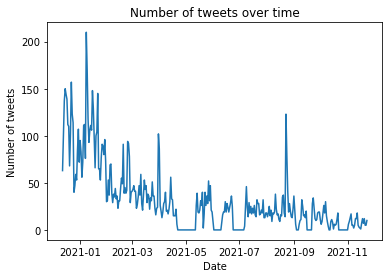

In [8]:
# Convert timestamp column to datetime
text_dataset['date'] = pd.to_datetime(text_dataset['date'], format='%m/%d/%Y %H:%M')

# Group the data by date and get the count of tweets per day
daily_tweets = text_dataset.groupby(pd.Grouper(key='date', freq='D')).size()

# Plot the data
plt.plot(daily_tweets.index, daily_tweets.values)
plt.xlabel('Date')
plt.ylabel('Number of tweets')
plt.title('Number of tweets over time')
plt.show()

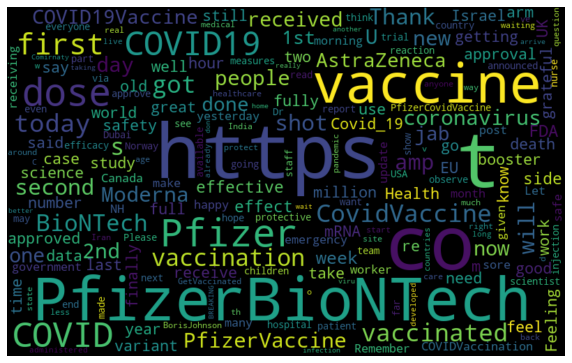

In [9]:
# Word cloud
text = ' '.join(text_dataset['text'])
wordcloud = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


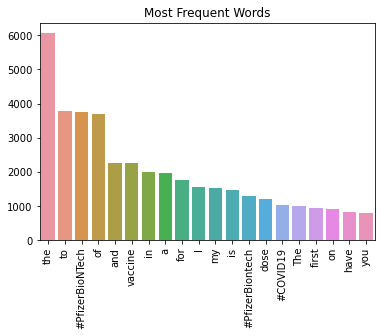

In [10]:
# Frequency of words
words = text.split()
freq_dist = pd.Series(words).value_counts()
sns.barplot(x=freq_dist[:20].index, y=freq_dist[:20])
plt.title('Most Frequent Words')
plt.xticks(rotation=90)
plt.show()

## 3. Data Preprocessing

### Cleaning, transforming, and reformatting

In [11]:
text_dataset.isnull().sum()

date         0
text         0
retweets     0
favorites    0
dtype: int64

In [12]:
# Lowercase
text_dataset['text'] = text_dataset['text'].str.lower()
text_dataset['text'].head()

0    same folks said daikon paste could treat a cyt...
1    while the world has been on the wrong side of ...
2    #coronavirus #sputnikv #astrazeneca #pfizerbio...
3    facts are immutable, senator, even when you're...
4    explain to me again why we need a vaccine @bor...
Name: text, dtype: object

In [13]:
# URL removal
text_dataset['text'] = text_dataset['text'].apply(lambda x: re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',x))
text_dataset['text'].head()

0    same folks said daikon paste could treat a cyt...
1    while the world has been on the wrong side of ...
2    #coronavirus #sputnikv #astrazeneca #pfizerbio...
3    facts are immutable, senator, even when you're...
4    explain to me again why we need a vaccine @bor...
Name: text, dtype: object

In [14]:
# Punctuation removal
punctuation_removal = str.maketrans('', '', string.punctuation)
text_dataset['text'] = text_dataset['text'].apply(lambda text: text.translate(punctuation_removal))
text_dataset['text'].head()

0    same folks said daikon paste could treat a cyt...
1    while the world has been on the wrong side of ...
2    coronavirus sputnikv astrazeneca pfizerbiontec...
3    facts are immutable senator even when youre no...
4    explain to me again why we need a vaccine bori...
Name: text, dtype: object

In [15]:
# Single character and double space removal
text_dataset['text'] = text_dataset['text'].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
text_dataset['text'] = text_dataset['text'].apply(lambda x: re.sub(r'\s+', ' ', x, flags=re.I))
text_dataset['text'].head()

0    same folks said daikon paste could treatcytoki...
1    while the world has been on the wrong side of ...
2    coronavirus sputnikv astrazeneca pfizerbiontec...
3    facts are immutable senator even when youre no...
4    explain to me again why we needvaccine borisjo...
Name: text, dtype: object

In [16]:
# Email removal
text_dataset['text']= text_dataset['text'].apply(lambda x: re.sub('@[^\s]+', ' ', x))
text_dataset['text'].head()

0    same folks said daikon paste could treatcytoki...
1    while the world has been on the wrong side of ...
2    coronavirus sputnikv astrazeneca pfizerbiontec...
3    facts are immutable senator even when youre no...
4    explain to me again why we needvaccine borisjo...
Name: text, dtype: object

In [17]:
# Create tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Tokenize text column
text_dataset['text'] = text_dataset['text'].apply(lambda x: tokenizer.tokenize(x))

# Print tokenized text
text_dataset['text'].head()

0    [same, folks, said, daikon, paste, could, trea...
1    [while, the, world, has, been, on, the, wrong,...
2    [coronavirus, sputnikv, astrazeneca, pfizerbio...
3    [facts, are, immutable, senator, even, when, y...
4    [explain, to, me, again, why, we, needvaccine,...
Name: text, dtype: object

In [18]:
# Stopword removal
stop_words = set(stopwords.words('english'))
text_dataset['text'] = text_dataset['text'].apply(lambda x: [word for word in x if word not in stop_words])
text_dataset['text'].head()

0    [folks, said, daikon, paste, could, treatcytok...
1    [world, wrong, side, history, year, hopefully,...
2    [coronavirus, sputnikv, astrazeneca, pfizerbio...
3    [facts, immutable, senator, even, youre, ethic...
4    [explain, needvaccine, borisjohnson, matthanco...
Name: text, dtype: object

In [19]:
# Load emoticon lookup table
with open('EmoticonLookupTable.txt', 'r') as f:
    emoticon_dict = {}
    for line in f:
        line = line.strip().split('\t')
        emoticon_dict[line[0]] = line[1]

# Define function to replace emoticons with sentiment labels
def replace_emoticons(tokens, emoticon_dict):
    # Join the tokens back into a string
    text = ' '.join(tokens)
    
    # Iterate over the emoticons and replace them with their sentiment labels
    for emoticon, polarity in emoticon_dict.items():
        pattern = re.compile(re.escape(emoticon), re.IGNORECASE)
        if polarity == '1':
            text = pattern.sub("positive", text)
        elif polarity == '-1':
            text = pattern.sub("negative", text)
        else:
            text = pattern.sub('', text)
    
    # Split the text back into tokens
    tokens = text.split()
    return tokens

# Apply the function to the 'text' column of the DataFrame
text_dataset['text'] = text_dataset['text'].apply(lambda x: replace_emoticons(x, emoticon_dict))
text_dataset['text'].head()

0    [folks, said, daikon, paste, could, treatcytok...
1    [world, wrong, side, history, year, hopefully,...
2    [coronavirus, sputnikv, astrazeneca, pfizerbio...
3    [facts, immutable, senator, even, youre, ethic...
4    [epositivelain, needvaccine, borisjohnson, mat...
Name: text, dtype: object

In [20]:
#Applying Stemming
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

text_dataset['text'] = text_dataset['text'].apply(lambda x: stemming_on_text(x))
text_dataset['text'].head()

0    [folks, said, daikon, paste, could, treatcytok...
1    [world, wrong, side, history, year, hopefully,...
2    [coronavirus, sputnikv, astrazeneca, pfizerbio...
3    [facts, immutable, senator, even, youre, ethic...
4    [epositivelain, needvaccine, borisjohnson, mat...
Name: text, dtype: object

In [21]:
#Applying Lemmatizer
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

text_dataset['text'] = text_dataset['text'].apply(lambda x: lemmatizer_on_text(x))
text_dataset['text'].head()

0    [folks, said, daikon, paste, could, treatcytok...
1    [world, wrong, side, history, year, hopefully,...
2    [coronavirus, sputnikv, astrazeneca, pfizerbio...
3    [facts, immutable, senator, even, youre, ethic...
4    [epositivelain, needvaccine, borisjohnson, mat...
Name: text, dtype: object

### Feature engineering & feature extraction 

In [22]:
# Convert the lists of words to strings
text_dataset['text'] = text_dataset['text'].apply(' '.join)
vect = CountVectorizer(ngram_range=(1,2)).fit(text_dataset['text'])
feature_names = vect.get_feature_names()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features:\n {}".format(feature_names[:20]))

Number of features: 80732

First 20 features:
 ['000', '000 doses', '000 initial', '000 people', '000 vaccines', '0000001', '0000001 covid19', '0011', '0011 abt', '004', '004 covid', '004 israelis', '01', '01 getting', '01 june', '01 november', '01aug2021', '01aug2021 doublevaxxed', '02', '02 175']


C:\Users\ngoc\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [23]:
X = text_dataset['text']
X = vect.transform(X)
X

<11020x80732 sparse matrix of type '<class 'numpy.int64'>'
	with 199773 stored elements in Compressed Sparse Row format>

## 4. Sentiment Analysis

In [24]:
# Define function to get value counts
def get_value_counts(col_name, analyzer_name):
    count = pd.DataFrame(text_dataset[col_name].value_counts())
    percentage = pd.DataFrame(text_dataset[col_name].value_counts(normalize=True).mul(100))
    value_counts_df = pd.concat([count, percentage], axis = 1)
    value_counts_df = value_counts_df.reset_index()
    value_counts_df.columns = ['sentiment', 'counts', 'percentage']
    value_counts_df.sort_values('sentiment', inplace = True)
    value_counts_df['percentage'] = value_counts_df['percentage'].apply(lambda x: round(x,2))
    value_counts_df = value_counts_df.reset_index(drop = True)
    value_counts_df['analyzer'] = analyzer_name
    return value_counts_df

### 4.1. NLTK VADER

In [25]:
sia = SentimentIntensityAnalyzer()

# Obtaining NLTK scores
text_dataset['nltk_scores'] = text_dataset['text'].apply(lambda x: sia.polarity_scores(x))

# Obtaining NLTK compound score
text_dataset['nltk_cmp_score'] = text_dataset['nltk_scores'].apply(lambda score_dict: score_dict['compound'])
neutral_thresh = 0.05

# Categorize scores into the sentiments of positive, neutral or negative
text_dataset['nltk_sentiment'] = text_dataset['nltk_cmp_score'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))

text_dataset['nltk_cmp_score'].describe()

count    11020.000000
mean         0.131986
std          0.346848
min         -0.913600
25%          0.000000
50%          0.000000
75%          0.421500
max          0.936000
Name: nltk_cmp_score, dtype: float64

In [26]:
nltk_sentiment_df = get_value_counts('nltk_sentiment','NLTK Vader')
nltk_sentiment_df

,sentiment,counts,percentage,analyzer
0,Negative,1642,14.90,NLTK Vader
1,Neutral,4929,44.73,NLTK Vader
2,Positive,4449,40.37,NLTK Vader


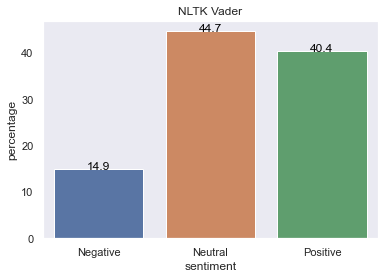

In [27]:
sns.set_theme(style="dark")
ax = sns.barplot(x="sentiment", y="percentage", data=nltk_sentiment_df)
ax.set_title('NLTK Vader')

for index, row in nltk_sentiment_df.iterrows():
    ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")

### 4.2. TextBlob

In [28]:
text_dataset['textblob_score'] = text_dataset['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
neutral_thresh = 0.05
# Convert polarity score into sentiment categories
text_dataset['textblob_sentiment'] = text_dataset['textblob_score'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))
text_dataset['textblob_score'].describe()

count    11020.000000
mean         0.098700
std          0.228562
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.211111
max          1.000000
Name: textblob_score, dtype: float64

In [29]:
textblob_sentiment_df = get_value_counts('textblob_sentiment','TextBlob')
textblob_sentiment_df

,sentiment,counts,percentage,analyzer
0,Negative,902,8.19,TextBlob
1,Neutral,5976,54.23,TextBlob
2,Positive,4142,37.59,TextBlob


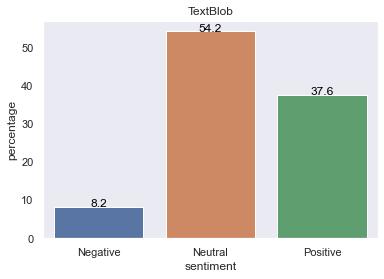

In [30]:
sns.set_theme(style="dark")
ax = sns.barplot(x="sentiment", y="percentage", data=textblob_sentiment_df)
ax.set_title('TextBlob')

for index, row in textblob_sentiment_df.iterrows():
    ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")

## 5. Comparison of models

In [31]:
text_dataset.head()

,date,text,retweets,favorites,nltk_scores,nltk_cmp_score,nltk_sentiment,textblob_score,textblob_sentiment
0,2020-12-20 06:06:00,folks said daikon paste could treatcytokine st...,0,0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,0.0,Neutral
1,2020-12-13 16:27:00,world wrong side history year hopefully bigges...,1,1,"{'neg': 0.209, 'neu': 0.608, 'pos': 0.182, 'co...",-0.1027,Negative,-0.5,Negative
2,2020-12-12 20:33:00,coronavirus sputnikv astrazeneca pfizerbiontec...,0,0,"{'neg': 0.0, 'neu': 0.846, 'pos': 0.154, 'comp...",0.2500,Positive,0.0,Neutral
3,2020-12-12 20:23:00,facts immutable senator even youre ethically s...,446,2129,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,0.1,Positive
4,2020-12-12 20:17:00,epositivelain needvaccine borisjohnson matthan...,0,0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,0.0,Neutral


In [32]:
df_sentiments = pd.concat([nltk_sentiment_df, textblob_sentiment_df]).reset_index(drop=True)
df_sentiments

,sentiment,counts,percentage,analyzer
0,Negative,1642,14.90,NLTK Vader
1,Neutral,4929,44.73,NLTK Vader
2,Positive,4449,40.37,NLTK Vader
3,Negative,902,8.19,TextBlob
4,Neutral,5976,54.23,TextBlob
5,Positive,4142,37.59,TextBlob


In [33]:
df_sentiments_pivot = df_sentiments.pivot(index='sentiment', columns='analyzer', values='percentage')
df_sentiments_pivot

analyzer,NLTK Vader,TextBlob
sentiment,,
Negative,14.90,8.19
Neutral,44.73,54.23
Positive,40.37,37.59


In [34]:
df_sentiments_pivot.to_csv('matrix.csv', index=False)

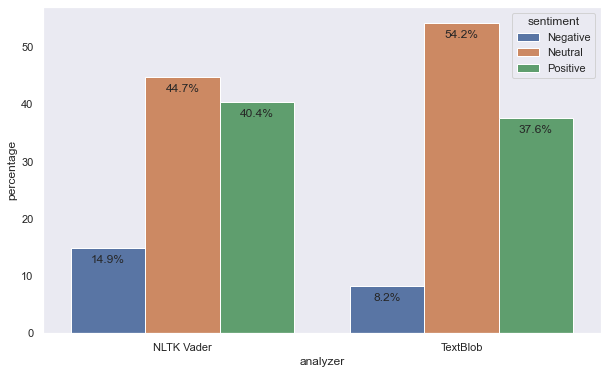

In [35]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x="analyzer", y="percentage",
                 hue="sentiment", data=df_sentiments)

# Display annotations
for p in ax.patches:
    ax.annotate(f"{round(p.get_height(),1)}%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=12,
                   xytext = (0, -12), 
                   textcoords = 'offset points')

In [36]:
# Compute the correlation between the sentiment scores and the number of likes
favorites_correlation_vader = text_dataset['favorites'].corr(text_dataset['nltk_cmp_score'])
favorites_correlation_textblob = text_dataset['favorites'].corr(text_dataset['textblob_score'])

print("Correlation between Vader sentiment scores and number of favorites: {:.2f}".format(favorites_correlation_vader))
print("Correlation between TextBlob sentiment scores and number of favorites: {:.2f}".format(favorites_correlation_textblob))

Correlation between Vader sentiment scores and number of favorites: 0.04
Correlation between TextBlob sentiment scores and number of favorites: 0.02


In [37]:
# Compute the correlation between the sentiment scores and the number of likes
retweets_correlation_vader = text_dataset['retweets'].corr(text_dataset['nltk_cmp_score'])
retweets_correlation_textblob = text_dataset['retweets'].corr(text_dataset['textblob_score'])

print("Correlation between Vader sentiment scores and number of retweets: {:.2f}".format(retweets_correlation_vader))
print("Correlation between TextBlob sentiment scores and number of retweets: {:.2f}".format(retweets_correlation_textblob))


Correlation between Vader sentiment scores and number of retweets: -0.01
Correlation between TextBlob sentiment scores and number of retweets: 0.00


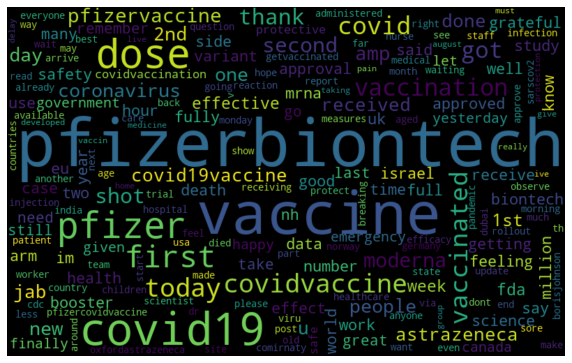

In [38]:
# Word cloud
text = ' '.join(text_dataset['text'])
wordcloud = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


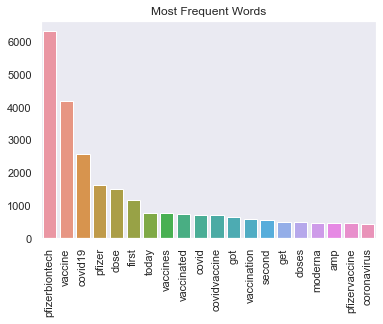

In [39]:
# Frequency of words
words = text.split()
freq_dist = pd.Series(words).value_counts()
sns.barplot(x=freq_dist[:20].index, y=freq_dist[:20])
plt.title('Most Frequent Words')
plt.xticks(rotation=90)
plt.show()


In [40]:
text_dataset.to_csv('results.csv', index=False)